<a href="https://colab.research.google.com/github/Minatozaki0911/Sudoku_VR/blob/main/Sudoku_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thu vien

In [15]:
import cv2
import numpy as np
import operator
from keras.models import load_model
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage import data, img_as_float
from skimage import exposure
from skimage import io

Class Sudoku: Chuyển đổi từ ảnh gốc sang ảnh với góc nhìn từ trên xuống

In [16]:
class Sudoku:
  def __init__(self,im):
    self.src = im
    self.contour_edges = self._contour_finder(im)
    self.conv_M, self.warped = self._perspective_transform(im,self.contour_edges)

  def _edges_finder(self, pts):
    pts = pts.reshape(4,2)

    xSorted = pts[np.argsort(pts[:, 0]), :]

	  # grab the left-most and right-most points from the sorted
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

	  # sort the left-most coordinates according to their
	  # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # use top-left coordinate as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

	  # return the coordinates in top-left, top-right,
	  # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

  def _perspective_transform(self,img,pts):
    tl = pts[0]
    tr = pts[1]
    br = pts[2]
    bl = pts[3]

    #max width
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA),int(widthB))

    #max height
    heightA = np.sqrt( ((tl[1]-bl[1])**2) + ((tl[0]-bl[0])**2) )
    heightB = np.sqrt( ((tr[1]-br[1])**2) + ((tr[0]-br[0])**2) )
    maxHeight = max(int(heightA),int(heightB))
    
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

    # return the warped image
    return M, warped
  
  def _contour_finder(self,img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(7,7),3)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)
    

    # find contours in the thresholded image and sort them by size in descending order
    cnts,hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    
    # initialize a contour that corresponds to the puzzle outline
    puzzleCnt = None
    # loop over the contours
    for c in cnts:
      # approximate the contour
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.02 * peri, True)
      # if our approximated contour has four points, then we can
      # assume we have found the outline of the puzzle
      if len(approx) == 4:
        puzzleCnt = approx
        break
    # if the puzzle contour is empty then our script could not find
  	# the outline of the Sudoku puzzle so raise an error
    if puzzleCnt is None:
      raise Exception(("Could not find Sudoku puzzle outline. ""Try debugging your thresholding and contour steps."))
    
    puzzleCnt = self._edges_finder(puzzleCnt.reshape([4,2]))
    return puzzleCnt

Img goc sang chuan & chuyen thanh list

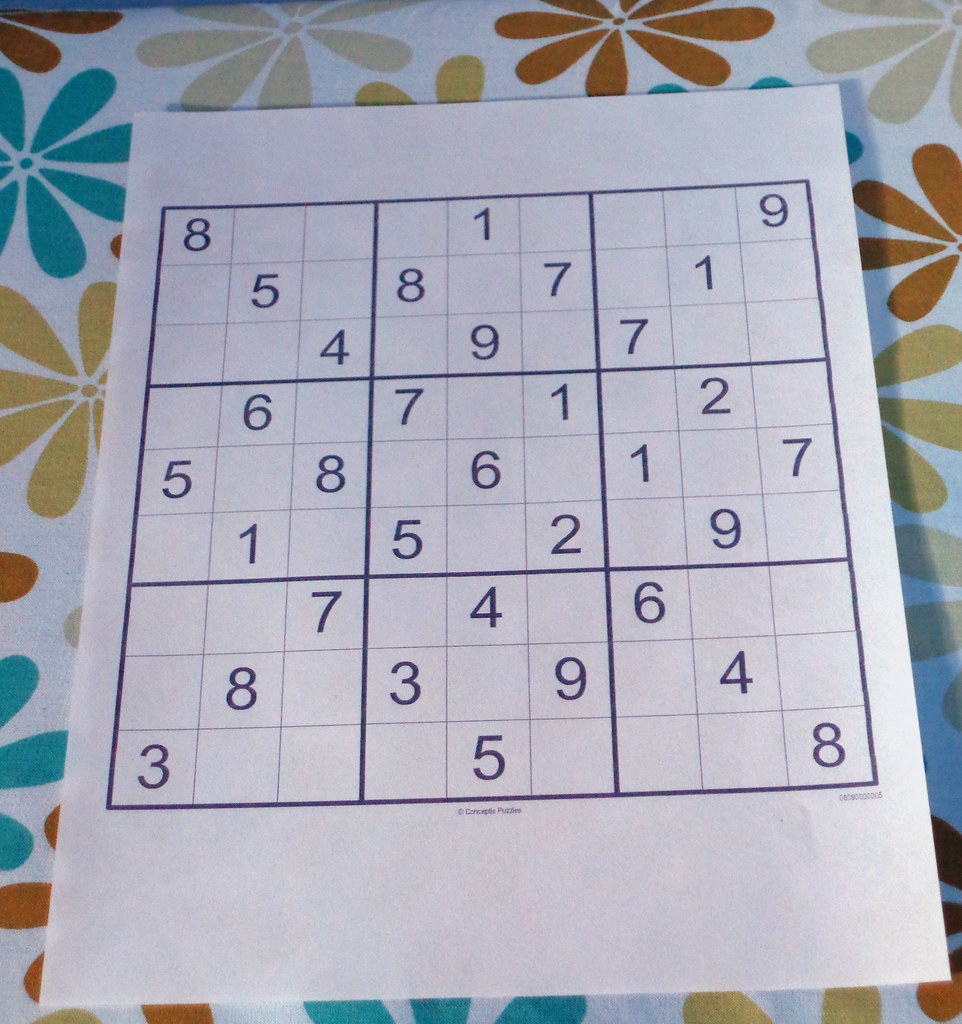

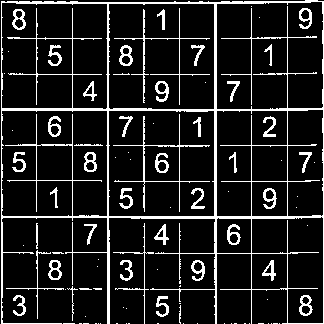

['800010009', '050807010', '004090700', '060701020', '508060107', '010502090', '007040600', '080309040', '300050008']


In [25]:
classifier = load_model("/content/digit_model.h5")
sudoku= io.imread('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg',0)
sudoku_orig = sudoku.copy()
cv2_imshow(sudoku)
marge = 4
case = 28 + 2 * marge
taille_grille = 9 * case
flag = 0

gray = cv2.cvtColor(sudoku, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)

contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_grille = None
maxArea = 0

for c in contours:
        area = cv2.contourArea(c)
        if area > 25000:
            peri = cv2.arcLength(c, True)
            polygone = cv2.approxPolyDP(c, 0.01 * peri, True)
            if area > maxArea and len(polygone) == 4:
                contour_grille = polygone
                maxArea = area
if contour_grille is not None:
        cv2.drawContours(sudoku, [contour_grille], 0, (0, 255, 0), 2)
        points = np.vstack(contour_grille).squeeze()
        points = sorted(points, key=operator.itemgetter(1))
        if points[0][0] < points[1][0]:
            if points[3][0] < points[2][0]:
                pts1 = np.float32([points[0], points[1], points[3], points[2]])
            else:
                pts1 = np.float32([points[0], points[1], points[2], points[3]])
        else:
            if points[3][0] < points[2][0]:
                pts1 = np.float32([points[1], points[0], points[3], points[2]])
            else:
                pts1 = np.float32([points[1], points[0], points[2], points[3]])
        pts2 = np.float32([[0, 0], [taille_grille, 0], [0, taille_grille], [
                          taille_grille, taille_grille]])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        grille = cv2.warpPerspective(sudoku, M, (taille_grille, taille_grille))
        #Phan cua Thuc
        grille = cv2.cvtColor(grille, cv2.COLOR_BGR2GRAY)
        grille = cv2.adaptiveThreshold(
            grille, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 8)
        cv2_imshow( grille)
        if flag == 0:

            grille_txt = []
            for y in range(9):
                ligne = ""
                for x in range(9):
                    y2min = y * case + marge
                    y2max = (y + 1) * case - marge
                    x2min = x * case + marge
                    x2max = (x + 1) * case - marge
                    cv2.imwrite("mat" + str(y) + str(x) + ".png",
                                grille[y2min:y2max, x2min:x2max])
                    img = grille[y2min:y2max, x2min:x2max]
                    x = img.reshape(1, 28, 28, 1)
                    if x.sum() > 10000:
                        prediction = classifier.predict(x)
                        classes=np.argmax(prediction,axis=1)
                        ligne += "{:d}".format(classes[0])
                    else:
                        ligne += "{:d}".format(0)
                grille_txt.append(ligne)
            print(grille_txt)
        wrapped_sudoku =  cv2.cvtColor(grille, cv2.COLOR_GRAY2BGR)
        wrapped_sudoku = 255 - wrapped_sudoku.astype(np.uint8)

In [26]:
a = np.array(grille_txt)
b=[]
for i in range(9):
  string_a = a[i]
  arr = list(string_a)
  b.append(arr)
print(b)
bang_out = np.array(b).reshape((9, 9))
bang_out = np.array(b, dtype=np.uint8)
print(bang_out)

[['8', '0', '0', '0', '1', '0', '0', '0', '9'], ['0', '5', '0', '8', '0', '7', '0', '1', '0'], ['0', '0', '4', '0', '9', '0', '7', '0', '0'], ['0', '6', '0', '7', '0', '1', '0', '2', '0'], ['5', '0', '8', '0', '6', '0', '1', '0', '7'], ['0', '1', '0', '5', '0', '2', '0', '9', '0'], ['0', '0', '7', '0', '4', '0', '6', '0', '0'], ['0', '8', '0', '3', '0', '9', '0', '4', '0'], ['3', '0', '0', '0', '5', '0', '0', '0', '8']]
[[8 0 0 0 1 0 0 0 9]
 [0 5 0 8 0 7 0 1 0]
 [0 0 4 0 9 0 7 0 0]
 [0 6 0 7 0 1 0 2 0]
 [5 0 8 0 6 0 1 0 7]
 [0 1 0 5 0 2 0 9 0]
 [0 0 7 0 4 0 6 0 0]
 [0 8 0 3 0 9 0 4 0]
 [3 0 0 0 5 0 0 0 8]]


### Giải

In [27]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True


def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None

### Khang

In [28]:
tri_solve = bang_out.copy()
solve(tri_solve)
print(tri_solve)

[[8 7 2 4 1 3 5 6 9]
 [9 5 6 8 2 7 3 1 4]
 [1 3 4 6 9 5 7 8 2]
 [4 6 9 7 3 1 8 2 5]
 [5 2 8 9 6 4 1 3 7]
 [7 1 3 5 8 2 4 9 6]
 [2 9 7 1 4 8 6 5 3]
 [6 8 5 3 7 9 2 4 1]
 [3 4 1 2 5 6 9 7 8]]


In [29]:
# Matrix này lấy từ đầu ra của Bằng
sudoku_matrix = bang_out
# Solution này sẽ lấy từ đầu ra của Trí. Tạm thời t lấy random
solution = tri_solve.astype('str')

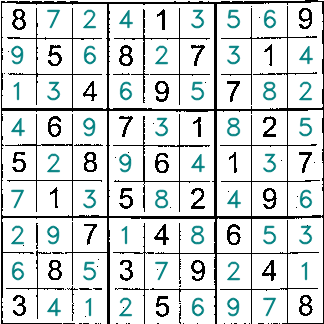

In [30]:
cell_width = wrapped_sudoku.shape[1] // 9
cell_height = wrapped_sudoku.shape[0] // 9
FONT = cv2.FONT_HERSHEY_DUPLEX
FONT_COLOR = (128,128,0)
FONT_THICCNESS = 1
FONT_SCALE = cv2.getFontScaleFromHeight(FONT, cell_height//2, FONT_THICCNESS)

for i in range(9):
  for j in range(9):
    if sudoku_matrix[i,j] == 0:
      ans =  solution[j,i]
      (text_width, text_height), baseline = cv2.getTextSize(ans, FONT, FONT_SCALE, FONT_THICCNESS)
      text_x = i * cell_width + (cell_width - text_width) // 2 
      text_y = j * cell_height + (cell_height + text_height) // 2
      sudoku_ans = cv2.putText(wrapped_sudoku, ans, 
                               (text_x, text_y), 
                                FONT, FONT_SCALE, FONT_COLOR, FONT_THICCNESS, cv2.LINE_AA)

    else:
      pass
cv2_imshow(sudoku_ans)


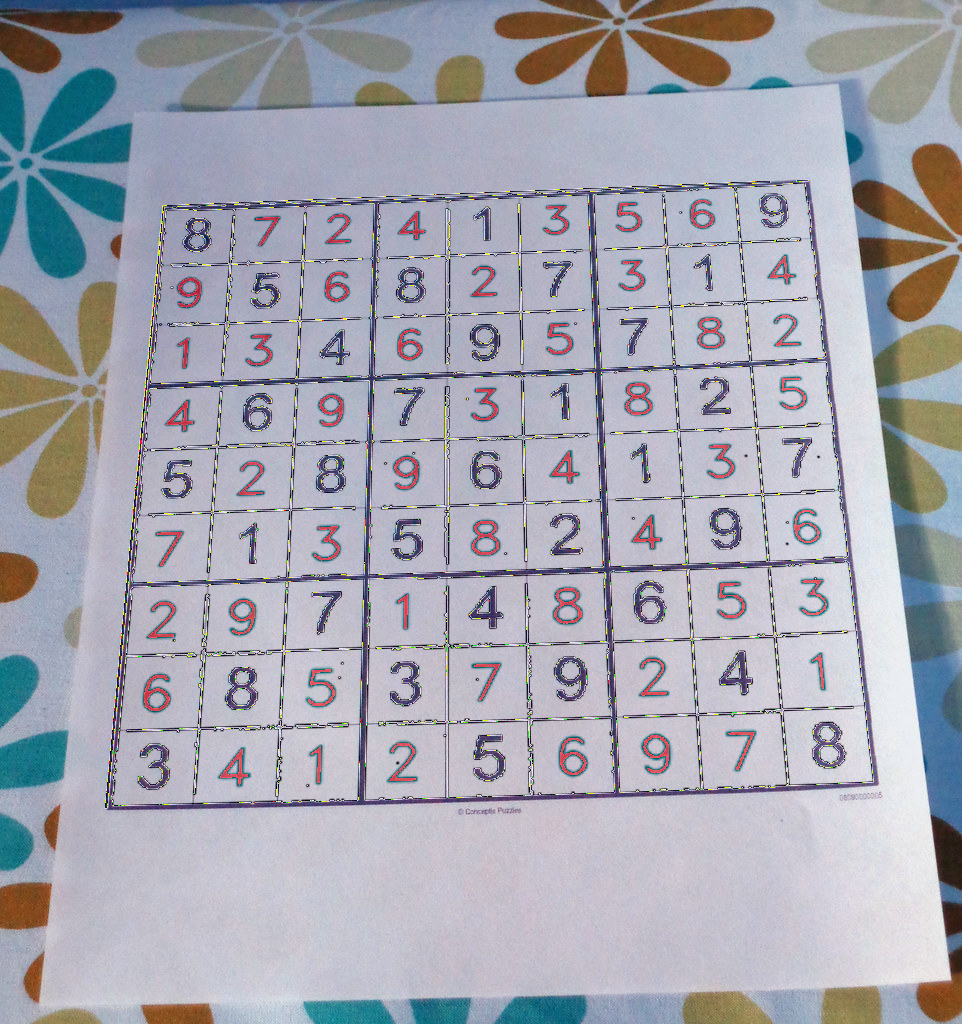

In [31]:
N = np.linalg.inv(M)
unwrapped = cv2.warpPerspective(wrapped_sudoku, N, (sudoku.shape[1], sudoku.shape[0]))
output = sudoku_orig + unwrapped
cv2_imshow(output)